In [1]:
import pandas as pd

# Data Exploration

In [2]:
train_df = pd.read_csv('../raw_data/training.csv')
test_df = pd.read_csv('../raw_data/test.csv')
validation_df = pd.read_csv('../raw_data/validation.csv')

In [3]:
train_df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [4]:
label_occurances = train_df.groupby('label').size().reset_index()
label_occurances.columns = ['label', 'occurances'] 

In [73]:
train_df['label'].unique()

array([0, 3, 2, 5, 4, 1])

In [88]:
def category(id):
    dict = {
        0: 'sadness',
        1: 'joy',
        2: 'love', 
        3: 'anger',
        4: 'fear',
        5: 'surprised'
    }

    return dict.get(id, f'Invalid id {id}')

## Data balance

In [90]:
label_percentages_df = (
    train_df['label']
    .value_counts(normalize=True)
    .mul(100)
    .round(2)
    .reset_index()
)

# Rename columns
label_percentages_df.columns = ['label', 'percentage']

full_stats = merged_df = pd.merge(label_occurances, label_percentages_df, on='label', how='inner')
full_stats['emotion'] = full_stats['label'].apply(category)
print(full_stats)

   label  occurances  percentage    emotion
0      0        4666       29.16    sadness
1      1        5362       33.51        joy
2      2        1304        8.15       love
3      3        2159       13.49      anger
4      4        1937       12.11       fear
5      5         572        3.58  surprised


## Text insights

In [91]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [92]:
X = train_df['text']

tk = Tokenizer()
tk.fit_on_texts(X)
vocab_size = len(tk.word_index)
print(f'There are {vocab_size} different words in your corpus')

There are 15212 different words in your corpus


In [93]:
train_df['length'] = train_df['text'].apply(lambda x: len(x.split()))
train_df.sort_values('length')

,text,label,length
9355,no response,3,2
4150,earth crake,4,2
12801,one day,0,2
12204,one night,1,2
12546,at school,3,2
...,...,...,...
46,i lost my special mind but don t worry i m sti...,1,64
7222,i am happier this year in all ways i am just g...,1,64
9626,i feel in my bones like nobody cares if im her...,0,64
9618,i feel you i dont believ in you but i keep my ...,1,64


<Axes: >

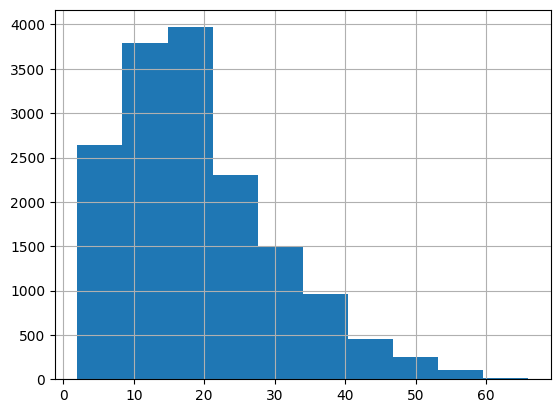

In [25]:
train_df.length.hist()

# Base Model

### Preprocessing

In [26]:
def pad(X, tk):
    X_token = tk.texts_to_sequences(X)
    return pad_sequences(X_token, dtype='float32', padding='post', maxlen=30)

In [27]:
X_pad = pad(X, tk)
X_pad.shape

(16000, 30)

### Model architecture

In [29]:
from tensorflow.keras import Sequential, Input, layers

embedding_size = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size + 1, output_dim=embedding_size, mask_zero=True))
model.add(layers.Conv1D(16, kernel_size=3))
model.add(layers.Flatten())
model.add(layers.Dense(5,))
model.add(layers.Dense(6, activation='softmax'))

### Model fitting

In [81]:
from tensorflow.keras.callbacks import EarlyStopping

y = train_df['label']

X_val = pad(validation_df['text'], tk)
y_val = validation_df['label']

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

es = EarlyStopping(patience=5, restore_best_weights=True)
model.fit(
    X_pad, 
    y,
    validation_data=(X_val, y_val),
    # validation_split=0.3,
    epochs=50, 
    batch_size=32, 
    verbose=1, 
    callbacks=[es]
)

Epoch 1/50


/Users/tobiasurhaug/.pyenv/versions/3.10.6/envs/pocketcoach/lib/python3.10/site-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9884 - loss: 0.0399 - val_accuracy: 0.8360 - val_loss: 0.7415
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9907 - loss: 0.0291 - val_accuracy: 0.8335 - val_loss: 0.8286
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9949 - loss: 0.0200 - val_accuracy: 0.8265 - val_loss: 0.8302
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9956 - loss: 0.0175 - val_accuracy: 0.8270 - val_loss: 0.8774
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9950 - loss: 0.0184 - val_accuracy: 0.8245 - val_loss: 0.9071
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9960 - loss: 0.0176 - val_accuracy: 0.8195 - val_loss: 0.9267


In [69]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (16, 30, 50)           │       760,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (16, 28, 16)           │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (16, 448)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (16, 5)                │         2,245 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (16, 6)                │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,296,043 (8.76 MB)

 Trainable params: 765,347 (2.92 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,530,696 (5.84 MB)

### Model Evaluation

In [70]:
X_test = pad(test_df['text'], tk)
y_test = test_df['label']

evaluation = model.evaluate(X_test, y_test, return_dict=True)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step - accuracy: 0.8223 - loss: 0.6996


In [71]:
evaluation

{'accuracy': 0.8299999833106995, 'loss': 0.6813883185386658}

In [95]:
test = ["I’m so frustrated right now! How many times do I have to explain this? It’s like nobody listens or cares. This constant nonsense is driving me crazy. I’ve had enough of being ignored and overlooked. Something needs to change — immediately. This situation is completely unacceptable and unfair!"]

test_pad = pad(test, tk)
y_pred = model.predict(test_pad)

get_emotion_from_prediction(y_pred[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


'sadness'

In [82]:
def get_emotion_from_prediction(y_pred):
    highest_proba = -1
    label_id = -1
    for i, probability in enumerate(y_pred):
        if probability > highest_proba:
            highest_proba = probability
            label_id = i


    return category(label_id)
    

## Word2Vec

In [38]:
train_sentences = train_df['text']
train_labels = train_df['label']

test_sentences = test_df['text']
test_labels = test_df['label']

In [39]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

X_train = [text_to_word_sequence(sentence) for sentence in train_sentences]
X_test = [text_to_word_sequence(sentence) for sentence in test_sentences]

### Train Word2Vec

In [50]:
from gensim.models import Word2Vec

vector_size = 50
min_count = 5
window_size = 3
word2vec = Word2Vec(sentences=X_train, vector_size=vector_size, min_count=min_count, window=window_size)

In [51]:
word2vec.wv.most_similar('happy', 10)

[('sure', 0.6436328291893005),
 ('really', 0.6365910172462463),
 ('passionate', 0.6192165613174438),
 ('though', 0.6084685325622559),
 ('anything', 0.6067778468132019),
 ('blessed', 0.5875459909439087),
 ('excited', 0.5818597674369812),
 ('angry', 0.5803570747375488),
 ('sorry', 0.5729061961174011),
 ('just', 0.5642852783203125)]

### Pre-trained embeddings

In [54]:
import gensim.downloader

print(list(gensim.downloader.info()['models'].keys()))

model_twitter = gensim.downloader.load('glove-twitter-25')

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [55]:
model_twitter.most_similar('happy', 10)

[('selamatpagi', 0.7792333960533142),
 ('kaliaaan', 0.7415818572044373),
 ('يآقيوم', 0.7407386302947998),
 ('kaliaan', 0.7322357892990112),
 ('آعظــمُ', 0.7226245999336243),
 ('kaliann', 0.7160356640815735),
 ('kaliaann', 0.7066093683242798),
 ('오빠의', 0.7052625417709351),
 ('cantiiik', 0.7042316794395447),
 ('우리오빠', 0.7016592621803284)]